In [73]:
import sklearn.cluster
import numpy as np
import matplotlib.pyplot as plt

def vector_quantization(img, num_clusters):
    X = img.reshape((-1, 1))
    kmeans = sklearn.cluster.KMeans(num_clusters)
    kmeans.fit(X)
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    X_quantized = centroids[labels]
    comp_img = X_quantized.reshape(img.shape)
    
    cf = 8/np.log2(num_clusters)
    return comp_img, cf

def quantization(img, n_bits):
    cf = 8/n_bits
    coef = 2**(8-n_bits)
    comp_img = img // coef * coef
    return comp_img, cf

In [56]:
img = plt.imread('../../data/other/lenna.png')
grey_img = np.mean(img, -1)*255

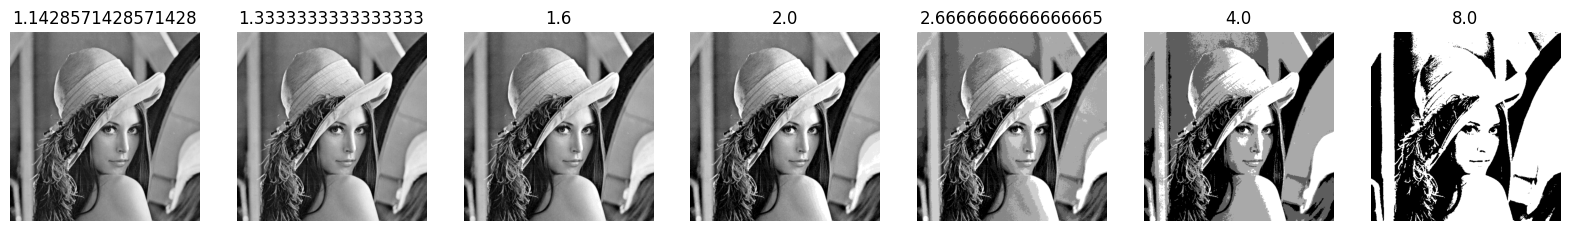

In [57]:
num_clusters_ = [128, 64, 32, 16, 8, 4, 2]

fig, ax_= plt.subplots(1, len(num_clusters_), figsize=(20, 20))
for i, ax in enumerate(ax_):
    comp_img, cf = vector_quantization(grey_img, num_clusters_[i])
    ax.imshow(comp_img, cmap='gray')
    ax.set_title(cf)
    ax.axis("off")

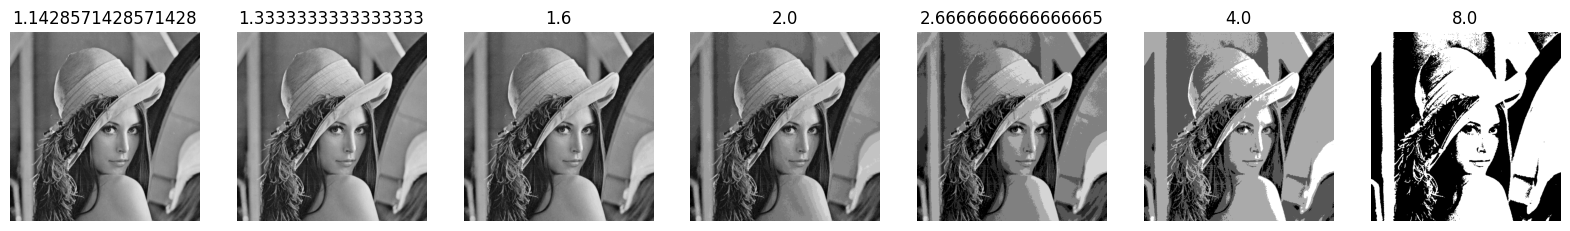

In [74]:
num_bits_ = [7, 6, 5, 4, 3, 2, 1]

fig, ax_= plt.subplots(1, len(num_clusters_), figsize=(20, 20))
for i, ax in enumerate(ax_):
    comp_img, cf = quantization(grey_img, num_bits_[i])
    ax.imshow(comp_img, cmap='gray')
    ax.set_title(cf)
    ax.axis("off")